In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Implementacja funkcji celu

In [2]:
def f(x: np.ndarray) -> float:
    # Przyjmuje x - np.array wymiaru (2,)
    # Zwraca wartość funkcji f w punkcie x - liczba

    # Wersja stabilna numerycznie
    p1 = np.logaddexp(0, x[0])
    p2 = np.logaddexp(0, 2*x[1])
    return p1 + p2 + x[0]*x[0]/4 + x[1]*x[1]/2

    # Wersja bezpośrednia
    #return np.log(1+np.exp(x[0])) + np.log(1+np.exp(2*x[1])) + x[0]*x[0]/4 + x[1]*x[1]/2

def sigmoid(s: float) -> float:
    # Przyjmuje s - liczba lub np.array dowolnego wymiaru
    # Zwraca sigmoid(s) - liczba lub np.array dowolnego wymiaru

    s = np.clip(s, -500, 500)  # unikanie overflowu
    return 1/(1+np.exp(-s))

def grad_f(x: np.ndarray) -> np.ndarray:
    # Przyjmuje x - np.array wymiaru (2,)
    # Zwraca wektor gradientu wymiaru (2,)
    return np.array([
        sigmoid(x[0]) + x[0]/2,
        2*sigmoid(2*x[1]) + x[1]
    ])

def hes_f(x: np.ndarray) -> np.ndarray:
    # Przyjmuje x - np.array wymiaru (2,)
    # Zwraca macierz Hessego wymiaru (2,2)
    return np.array([
        [1/2 + sigmoid(x[0]) * (1-sigmoid(x[0])),0],
        [0, 1 + 4*sigmoid(2*x[1])*(1-sigmoid(2*x[1]))]
    ])

In [3]:
# Funkcja f, grad_f, hes_f w punkcie (0, 10)
ptk = np.array([0.0, 10.0])
print("f(ptk) =", f(ptk))
print("grad_f(ptk) =", grad_f(ptk))
print("hes_f(ptk) = \n", hes_f(ptk))

f(ptk) = 70.69314718262109
grad_f(ptk) = [ 0.5 12. ]
hes_f(ptk) = 
 [[0.75       0.        ]
 [0.         1.00000001]]


## Krok 2: Szczegóły implementacji 

### Warunek stopu

Będziemy implementować różne algorytmy iteracyjne do optymalizacji tej funkcji. Jako kryterium stopu użyjemy normy gradientu:

`while np.linalg.norm(grad_f(x_k)) > eps:`

gdzie `eps` jest dodatnim parametrem. Przetestuj kilka, np.: `eps = 0.00001`.

### Notacja

Implementowane algorytmy będą przyjmować:
- f - funkcja celu (obiekt `Callable`)
- grad_f - funkcja zwracająca gradient funkcji f w danym punkcie
- hes_f - funkcja zwracająca hesjan funkcji f w danym punkcie (opcjonalnie)
- x0 - punkt startowy
- eps - parametr warunku stopu
- pozostałe parametry metody

Powinny natomiast zwracać:
- punkt końcowy do którego zbiegła metoda
- listę odwiedzonych punktów
- wartości funkcji f na każdym z odwiedzonych punktów

## Krok 3: Algorytm chciwca ze stałym krokiem

Zaimplementuj algorytm największego spadku ze stałym krokiem `alpha`:

$$x_{k+1} = x_k - \alpha \cdot \nabla f(x_k)$$

In [46]:
def GD_const_alpha(f, grad_f, x0, eps, alpha):
    # alpha - długość kroku

    lista_odwiedzonych_x = [x0]
    lista_wartosci_f = [f(x0)]
    x_k = x0
    grad_f_k = grad_f(x_k)
    while np.linalg.norm(grad_f_k) > eps:
        x_k = x_k - alpha * grad_f_k
        lista_odwiedzonych_x.append(x_k)
        lista_wartosci_f.append(f(x_k))
        grad_f_k = grad_f(x_k)
    
    x_star = x_k
        
    return (x_star, lista_odwiedzonych_x, lista_wartosci_f)

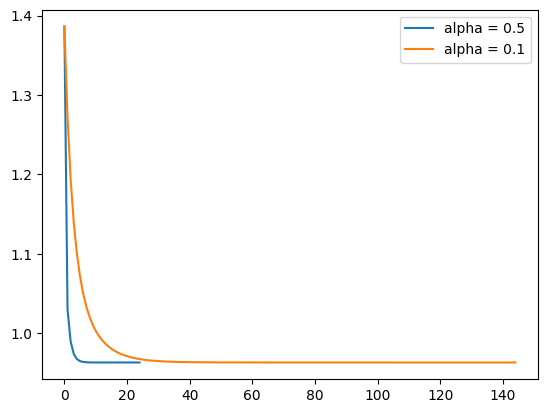

In [47]:
x0 = np.array([0,0])

my_eps = 1e-5

res_0_5 = GD_const_alpha(f, grad_f, x0, eps=my_eps, alpha=0.5)
res_0_01 = GD_const_alpha(f, grad_f, x0, eps=my_eps, alpha=0.1)

plt.plot(res_0_5[2], label="alpha = 0.5")
plt.plot(res_0_01[2], label="alpha = 0.1")
plt.legend()
plt.show()

## Krok 4: Proste metody optymalizacji jednej zmiennej

Algorytm Fibonacciego

In [48]:
def Fib(g, alpha_min, alpha_max, n_iter):
    assert n_iter >= 2, "Liczba iteracji musi być co najmniej 2"
    assert alpha_min < alpha_max, "alpha_min musi być mniejsze od alpha_max"
 
    a, b = alpha_min, alpha_max 
    r = (np.sqrt(5) - 1) / 2
    lambda_1 = a + r ** 2 * (b - a)
    lambda_2 = b - r ** 2 * (b - a)
    g1, g2 = g(lambda_1), g(lambda_2)
 
    for k in range(1, n_iter):
        if g1 >= g2:
            a = lambda_1
            lambda_1 = lambda_2
            lambda_2 = b - r ** 2 * (b - a)
            g1 = g2
            g2 = g(lambda_2)
        else:
            b = lambda_2
            lambda_2 = lambda_1
            lambda_1 = a + r ** 2 * (b - a)
            g2 = g1
            g1 = g(lambda_1)
 
    alpha_star = 0.5 * (a + b)
    return alpha_star


Backtracking

In [7]:
def BT(g, g_prime_0, alpha_0, rho=0.8, c=0.1):
    assert 0 < rho < 1, "rho musi być w przedziale (0, 1)"
    assert 0 < c < 1, "c musi być w przedziale (0, 1)"
    assert alpha_0 > 0, "alpha_0 musi być większe od 0"

    g0 = g(0.0)
    alpha = alpha_0

    for _ in range(10000):
        if g(alpha) <= g0 + c * alpha * g_prime_0:
            return alpha
        alpha *= rho

    return alpha

## Krok 5: Algorytm chciwca z minimalizacją w kierunku


In [49]:
def GD_Fib(f, grad_f, x0, eps, alpha_min, alpha_max, n_iter_Fib, max_iters=10000):
    # alpha_min, alpha_max - przedział do szukania kroku
    # n_iter_Fib - liczba iteracji algorytmu Fibonacciego
    # max_iters - maksymalna liczba iteracji algorytmu GD

    lista_odwiedzonych_x = [x0]
    lista_wartosci_f = [f(x0)]
    x_k = x0.copy()

    for _ in range(max_iters):
        grad_f_x_k = grad_f(x_k)
        if np.linalg.norm(grad_f_x_k) <= eps:
            break

        p = -grad_f_x_k

        def g(alpha):
            return f(x_k + alpha * p)

        alpha_star = Fib(g, alpha_min, alpha_max, n_iter_Fib)
        x_k = x_k + alpha_star * p
        lista_odwiedzonych_x.append(x_k.copy())
        lista_wartosci_f.append(f(x_k))

    x_star = x_k

    return (x_star, lista_odwiedzonych_x, lista_wartosci_f)

In [50]:
def GD_BT(f, grad_f, x0, eps, alpha_0, rho = 0.8, c = 0.1, max_iter = 10000):
    # alpha_0 - początkowa długość kroku
    # rho - współczynnik zmniejszania długości kroku
    # c - parametr Armijo
    # max_iters - maksymalna liczba iteracji algorytmu GD

    lista_odwiedzonych_x = [x0]
    lista_wartosci_f = [f(x0)]
    x_k = x0.copy()

    for _ in range(max_iter):
        grad_f_x_k = grad_f(x_k)
        if np.linalg.norm(grad_f_x_k) <= eps:
            break

        p = -grad_f_x_k

        def g(alpha):
            return f(x_k + alpha * p)
        g_prime_0 = np.dot(grad_f_x_k, p)

        alpha_star = BT(g, g_prime_0, alpha_0, rho, c)
        x_k = x_k + alpha_star * p

        lista_odwiedzonych_x.append(x_k.copy())
        lista_wartosci_f.append(f(x_k))

    x_star = x_k
    return (x_star, lista_odwiedzonych_x, lista_wartosci_f)

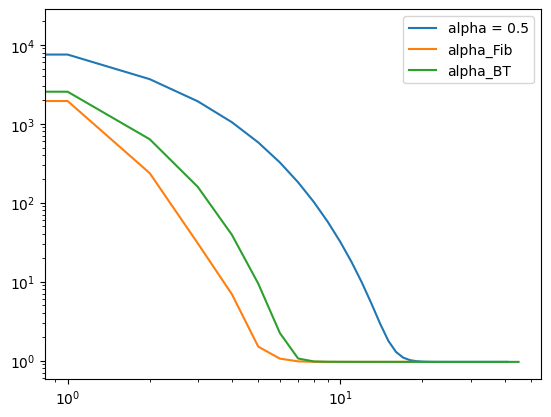

In [51]:
# x0 = np.array([0,0])
x0 = np.array([200,-120])

my_eps = 1e-5

res_0_5 = GD_const_alpha(f, grad_f, x0, eps=my_eps, alpha=0.5)
res_Fib = GD_Fib(f, grad_f, x0, eps=my_eps, alpha_min=0, alpha_max=10, n_iter_Fib=100)
res_BT = GD_BT(f, grad_f, x0, eps=my_eps, alpha_0=1)

plt.plot(res_0_5[2], label="alpha = 0.5")
plt.plot(res_Fib[2], label="alpha_Fib")
plt.plot(res_BT[2], label="alpha_BT")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

## Krok 6: Algorytm Newtona


In [52]:
def Newton_const_alpha(f, grad_f, hes_f, x0, eps, alpha=1.0, max_iter=200):
    # alpha - długość kroku
    # max_iter - maksymalna liczba iteracji

    lista_odwiedzonych_x = [x0]
    lista_wartosci_f = [f(x0)]
    x_k = x0.copy()

    for _ in range(max_iter):
        grad_f_x_k = grad_f(x_k)
        if np.linalg.norm(grad_f_x_k) <= my_eps:
            break
        hes_f_x_k = hes_f(x_k)
        p = np.linalg.solve(hes_f_x_k, -grad_f_x_k) # O(n^3) :<
        x_k = x_k + alpha * p
        lista_odwiedzonych_x.append(x_k.copy())
        lista_wartosci_f.append(f(x_k))
    x_star = x_k
    return (x_star, lista_odwiedzonych_x, lista_wartosci_f)

In [53]:
def Newton_Fib(f, grad_f, hes_f, x0, eps, alpha_min, alpha_max, n_iter_Fib, max_iter=200):
    # alpha_min, alpha_max - przedział do szukania kroku
    # n_iter_Fib - liczba iteracji algorytmu Fibonacciego
    # max_iter - maksymalna liczba iteracji

    lista_odwiedzonych_x = [x0]
    lista_wartosci_f = [f(x0)]
    x_k = x0.copy()

    for _ in range(max_iter):
        grad_f_x_k = grad_f(x_k)
        if np.linalg.norm(grad_f_x_k) <= eps:
            break
        hes_f_x_k = hes_f(x_k)
        p = np.linalg.solve(hes_f_x_k, -grad_f_x_k)

        def g(alpha):
            return f(x_k + alpha * p)

        alpha_star = Fib(g, alpha_min, alpha_max, n_iter_Fib)
        x_k = x_k + alpha_star * p
        lista_odwiedzonych_x.append(x_k.copy())
        lista_wartosci_f.append(f(x_k))
    x_star = x_k
    return (x_star, lista_odwiedzonych_x, lista_wartosci_f)

In [54]:
def Newton_BT(f, grad_f, hes_f, x0, eps, alpha_0 = 1, rho = 0.8, c = 0.1, max_iters_BT = 10000, max_iters=200):
    # alpha_0 - początkowa długość kroku
    # rho - współczynnik zmniejszania długości kroku
    # c - parametr Armijo
    # max_iters_BT - liczba iteracji algorytmu BT
    # max_iters - maksymalna liczba iteracji

    
    lista_odwiedzonych_x = [x0]
    lista_wartosci_f = [f(x0)]
    x_k = x0.copy()

    for _ in range(max_iters):
        grad_f_x_k = grad_f(x_k)
        if np.linalg.norm(grad_f_x_k) <= eps:
            break
        hes_f_x_k = hes_f(x_k)
        p = np.linalg.solve(hes_f_x_k, -grad_f_x_k)

        def g(alpha):
            return f(x_k + alpha * p)

        g_prime_0 = np.dot(grad_f_x_k, p)
        alpha_star = BT(g, g_prime_0, alpha_0, rho, c)
        x_k = x_k + alpha_star * p
        lista_odwiedzonych_x.append(x_k)
        lista_wartosci_f.append(f(x_k))
    x_star = x_k
    return (x_star, lista_odwiedzonych_x, lista_wartosci_f)

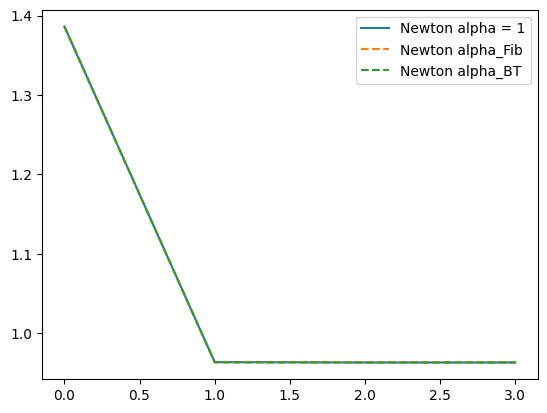

In [55]:
x0 = np.array([0,0])
#x0 = np.array([200,-120])

my_eps = 1e-5

res_N_const = Newton_const_alpha(f, grad_f, hes_f, x0, my_eps)
res_N_Fib = Newton_Fib(f, grad_f, hes_f, x0, my_eps, alpha_min=0.001, alpha_max=10, n_iter_Fib=200)
res_N_BT = Newton_BT(f, grad_f, hes_f, x0, my_eps)

plt.plot(res_N_const[2], label="Newton alpha = 1")
plt.plot(res_N_Fib[2], label="Newton alpha_Fib", linestyle="--")
plt.plot(res_N_BT[2], label="Newton alpha_BT", linestyle="--")
plt.legend()
plt.show()

## Metoda Quasi-Newtona
Rozważana funkcja Rosenbrocka

In [57]:
def r(x: np.ndarray) -> float:
    return 100 * (x[2] - x[1] ** 2) ** 2 + (1 - x[1]) ** 2 + 100 * (x[1] - x[0] ** 2) ** 2 + (1 - x[0]) ** 2

In [58]:
def grad_r(x: np.ndarray) -> np.ndarray:
    x0, x1, x2 = x
    df_dx0 = -400*x0*(x1 - x0**2) - 2*(1 - x0)
    df_dx1 = -400*x1*(x2 - x1**2) + 2*(x1 - 1) + 200*(x1 - x0**2)
    df_dx2 = 200*(x2 - x1**2)
    return np.array([df_dx0, df_dx1, df_dx2])

In [59]:
def hes_r(x: np.ndarray) -> np.ndarray:
    x0, x1, x2 = x
    H = np.array([
        [1200*x0**2 - 400*x1 + 2,   -400*x0,               0],
        [-400*x0,                   1200*x1**2 - 400*x2 + 202,  -400*x1],
        [0,                         -400*x1,               200]
    ])
    return H

In [60]:
def BFGS(f, grad_f, x0, eps, beta=0.1, alpha=1.0, max_iters=1000):
    """
    BFGS z stałym krokiem alpha (alpha_k = alpha).
    - f: funkcja skalarna przyjmująca wektor x (np.ndarray)
    - grad_f: funkcja zwracająca gradient (np.ndarray)
    - x0: punkt startowy (np.ndarray)
    - eps: tolerancja na normę gradientu (kryterium stopu)
    - beta: wartość na diagonali początkowego H0 = beta * I
    - alpha: stały krok (np. 1.0)
    - max_iters: maksymalna liczba iteracji
    Zwraca (x_star, lista_odwiedzonych_x, lista_wartosci_f)
    """
    x = np.array(x0, dtype=float).copy()
    n = x.size

    H = beta * np.eye(n) 
    visited = [x.copy()]
    vals = [float(f(x))]

    for k in range(1, max_iters + 1):
        gk = grad_f(x)
        ng = np.linalg.norm(gk)
        if ng <= eps:
            break

        p = - H.dot(gk)
        x_new = x + alpha * p
        s = x_new - x

        g_new = grad_f(x_new)
        y = g_new - gk

        sTy = float(np.dot(s, y))

        Hy = H.dot(y)
        yHy = float(np.dot(y, Hy))  

        coeff1 = (sTy + yHy) / (sTy ** 2)
        term1 = coeff1 * np.outer(s, s)

        term2 = (np.outer(Hy, s) + np.outer(s, y.dot(H))) / sTy

        H = H + term1 - term2

        x = x_new
        visited.append(x.copy())
        vals.append(float(f(x)))

    return (x.copy(), visited, vals)

In [61]:
def BFGS_fib(f, grad_f, x0, eps,
             beta=0.1, max_iters=1000,
             alpha_min=1e-6, alpha_max=1.0, n_iter_Fib=20):
    """
    BFGS z wykorzystaniem Fibonacciego
    - f: funkcja skalarna przyjmująca wektor x (np.ndarray)
    - grad_f: funkcja zwracająca gradient (np.ndarray)
    - x0: punkt startowy (np.ndarray)
    - eps: tolerancja na normę gradientu (kryterium stopu)
    - beta: wartość na diagonali początkowego H0 = beta * I
    - max_iters: maksymalna liczba iteracji BFGS
    - alpha_min - minimalna wartość alphy przy ustalaniu kroku fibonaccim
    - alpha_max - maksymalna wartość alphy przy ustalaniu kroku fibonaccim
    - n_iter_Fib - ilość iteracji wyszukiwania alphy w algorytmie fibonacciego

    Zwraca (x_star, lista_odwiedzonych_x, lista_wartosci_f)
    """
    x = np.array(x0, dtype=float).copy()
    n = x.size

    H = beta * np.eye(n) 
    visited = [x.copy()]
    vals = [float(f(x))]

    for k in range(1, max_iters + 1):
        gk = grad_f(x)
        ng = np.linalg.norm(gk)
        if ng <= eps:
            break

        p = - H.dot(gk)
        def g(alpha_val):
            return float(f(x + alpha_val * p))
        Ncap = min(int(n_iter_Fib), 200)
        alpha_star = Fib(g, alpha_min, alpha_max, Ncap)
        x_new = x + alpha_star * p
        s = x_new - x

        g_new = grad_f(x_new)
        y = g_new - gk

        sTy = float(np.dot(s, y))

        Hy = H.dot(y)
        yHy = float(np.dot(y, Hy))  

        coeff1 = (sTy + yHy) / (sTy ** 2)
        term1 = coeff1 * np.outer(s, s)

        term2 = (np.outer(Hy, s) + np.outer(s, y.dot(H))) / sTy

        H = H + term1 - term2

        x = x_new
        visited.append(x.copy())
        vals.append(float(f(x)))

    return (x.copy(), visited, vals)

In [62]:
def BFGS_BT(f, grad_f, x0, eps, beta=0.1, alpha_0=1.0, max_iters=1000, rho = 0.8, c = 0.1):
    """
    BFGS z wykorzystaniem Backtrackingu
    - f: funkcja skalarna przyjmująca wektor x (np.ndarray)
    - grad_f: funkcja zwracająca gradient (np.ndarray)
    - x0: punkt startowy (np.ndarray)
    - eps: tolerancja na normę gradientu (kryterium stopu)
    - beta: wartość na diagonali początkowego H0 = beta * I
    - alpha_0: początkowa wartość alpha dla każdego kroku
    - max_iters: maksymalna liczba iteracji
    - rho - parametr mnożący alpha w każdym kroku BT
    - c - współczynnik Armijo
    Zwraca (x_star, lista_odwiedzonych_x, lista_wartosci_f)
    """
    x = np.array(x0, dtype=float).copy()
    n = x.size

    H = beta * np.eye(n) 
    visited = [x.copy()]
    vals = [float(f(x))]

    for k in range(1, max_iters + 1):
        gk = grad_f(x)
        ng = np.linalg.norm(gk)
        if ng <= eps:
            break

        p = - H.dot(gk)
        def g(alpha):
            return f(x + alpha * p)
        g_prime_0 = np.dot(gk, p)
        alpha_star = BT(g, g_prime_0, alpha_0, rho = rho, c = c)
        x_new = x + alpha_star * p
        s = x_new - x

        g_new = grad_f(x_new)
        y = g_new - gk

        sTy = float(np.dot(s, y))
        if sTy < 10e-12: # blocks from division by 0
            return (x.copy(), visited, vals)

        Hy = H.dot(y)
        yHy = float(np.dot(y, Hy))  

        coeff1 = (sTy + yHy) / (sTy ** 2)
        term1 = coeff1 * np.outer(s, s)

        term2 = (np.outer(Hy, s) + np.outer(s, y.dot(H))) / sTy

        H = H + term1 - term2

        x = x_new
        visited.append(x.copy())
        vals.append(float(f(x)))

    return (x.copy(), visited, vals)

In [63]:
idx = 1000

def print_result(name, visited_list, vals_list):
    if len(visited_list) > idx:
        print(f"{name}: punkt po iteracji {idx}: {visited_list[idx]}")
        print(f"{name}: wartość f po iteracji {idx}: {vals_list[idx]}")
    else:
        print(f"{name}: zakończyło przed {idx}-tą iteracją (wykonano {len(visited_list)-1}).")
        print(f"{name}: ostatni punkt: {visited_list[-1]}, wartość: {vals_list[-1]}")


In [64]:
x0 = np.array([-1.2, 1.0, 1.0])
eps = 1e-8
max_iters = 1000
alpha_min = 1e-6
alpha_max = 1.0
n_iter_Fib = 200

gd_methods = {
    "GD_const": lambda: GD_const_alpha(r, grad_r, x0, eps, alpha=1.0),
    "GD_BT":    lambda: GD_BT(r, grad_r, x0, eps, alpha_0=1.0, rho=0.8, c=0.1, max_iter=max_iters),
    "GD_Fib":   lambda: GD_Fib(r, grad_r, x0, eps, alpha_min=1e-6, alpha_max=1.0, n_iter_Fib=20, max_iters=max_iters)
}

newton_methods = {
    "Newton_const": lambda: Newton_const_alpha(r, grad_r, hes_r, x0, eps, alpha=1.0, max_iter=max_iters),
    "Newton_BT":    lambda: Newton_BT(r, grad_r, hes_r, x0, eps, alpha_0=1.0, rho=0.8, c=0.1, max_iters=max_iters),
    "Newton_Fib":   lambda: Newton_Fib(r, grad_r, hes_r, x0, eps, alpha_min=1e-6, alpha_max=1.0, n_iter_Fib=20, max_iter=max_iters)
}

bfgs_methods = {
    "BFGS_const": lambda: BFGS(r, grad_r, x0, eps, beta=0.1, alpha=1.0, max_iters=max_iters),
    "BFGS_Fib":   lambda: BFGS_fib(r, grad_r, x0, eps, beta=0.1, max_iters=max_iters, alpha_min=alpha_min, alpha_max=alpha_max, n_iter_Fib=n_iter_Fib),
    "BFGS_BT":    lambda: BFGS_BT(r, grad_r, x0, eps, beta=0.1, alpha_0=1.0, rho=0.8, c=0.1, max_iters=max_iters)
}

results_gd = {}
results_newton = {}
results_bfgs = {}

for name, fn in gd_methods.items():
    x_star, visited, vals = fn()
    results_gd[name] = (x_star, visited, vals)
    print(f"\n--- {name} ---")
    print_result(name, visited, vals)



--- GD_const ---
GD_const: zakończyło przed 1000-tą iteracją (wykonano 5).
GD_const: ostatni punkt: [7.74251876e+292 3.92252252e+261 9.16291445e+174], wartość: inf

--- GD_BT ---
GD_BT: punkt po iteracji 1000: [0.7847807  0.61318    0.37518918]
GD_BT: wartość f po iteracji 1000: 0.19674254812783604

--- GD_Fib ---
GD_Fib: punkt po iteracji 1000: [0.99974717 0.99949415 0.99898544]
GD_Fib: wartość f po iteracji 1000: 3.207835188195245e-07


C:\Users\Admin\AppData\Local\Temp\ipykernel_25260\4032893031.py:2: RuntimeWarning: overflow encountered in scalar power
  return 100 * (x[2] - x[1] ** 2) ** 2 + (1 - x[1]) ** 2 + 100 * (x[1] - x[0] ** 2) ** 2 + (1 - x[0]) ** 2
C:\Users\Admin\AppData\Local\Temp\ipykernel_25260\3719178522.py:3: RuntimeWarning: overflow encountered in scalar power
  df_dx0 = -400*x0*(x1 - x0**2) - 2*(1 - x0)
C:\Users\Admin\AppData\Local\Temp\ipykernel_25260\3719178522.py:4: RuntimeWarning: overflow encountered in scalar power
  df_dx1 = -400*x1*(x2 - x1**2) + 2*(x1 - 1) + 200*(x1 - x0**2)
C:\Users\Admin\AppData\Local\Temp\ipykernel_25260\3719178522.py:4: RuntimeWarning: invalid value encountered in scalar add
  df_dx1 = -400*x1*(x2 - x1**2) + 2*(x1 - 1) + 200*(x1 - x0**2)
C:\Users\Admin\AppData\Local\Temp\ipykernel_25260\3719178522.py:5: RuntimeWarning: overflow encountered in scalar power
  df_dx2 = 200*(x2 - x1**2)


In [65]:
for name, fn in newton_methods.items():
    x_star, visited, vals = fn()
    results_newton[name] = (x_star, visited, vals)
    print(f"\n--- {name} ---")
    print_result(name, visited, vals)


--- Newton_const ---
Newton_const: zakończyło przed 1000-tą iteracją (wykonano 19).
Newton_const: ostatni punkt: [1.         1.         0.99999999], wartość: 4.168610881222214e-15

--- Newton_BT ---
Newton_BT: zakończyło przed 1000-tą iteracją (wykonano 27).
Newton_BT: ostatni punkt: [1. 1. 1.], wartość: 3.097314432930574e-25

--- Newton_Fib ---
Newton_Fib: zakończyło przed 1000-tą iteracją (wykonano 28).
Newton_Fib: ostatni punkt: [1. 1. 1.], wartość: 1.179599119016534e-25


In [66]:
for name, fn in bfgs_methods.items():
    x_star, visited, vals = fn()
    results_bfgs[name] = (x_star, visited, vals)
    print(f"\n--- {name} ---")
    print_result(name, visited, vals)


--- BFGS_const ---
BFGS_const: zakończyło przed 1000-tą iteracją (wykonano 191).
BFGS_const: ostatni punkt: [1. 1. 1.], wartość: 4.290852815564883e-18

--- BFGS_Fib ---
BFGS_Fib: zakończyło przed 1000-tą iteracją (wykonano 44).
BFGS_Fib: ostatni punkt: [1. 1. 1.], wartość: 9.464112191356208e-28

--- BFGS_BT ---
BFGS_BT: zakończyło przed 1000-tą iteracją (wykonano 51).
BFGS_BT: ostatni punkt: [1.00000011 1.0000002  1.00000037], wartość: 1.5841614766009481e-13


Metody gradient descent nie zbiegają lub są bardzo wolne (BT). Jedynie Fibonacci zbiega

Metody Newtonowskie zbiegają najszybciej

W BFGS wszystkie metody zbiegają trochę wolniej niż w Newtonie. Z krokiem stałym potrzebne najwięcej iteracji.

#### Wykresy zbieżności

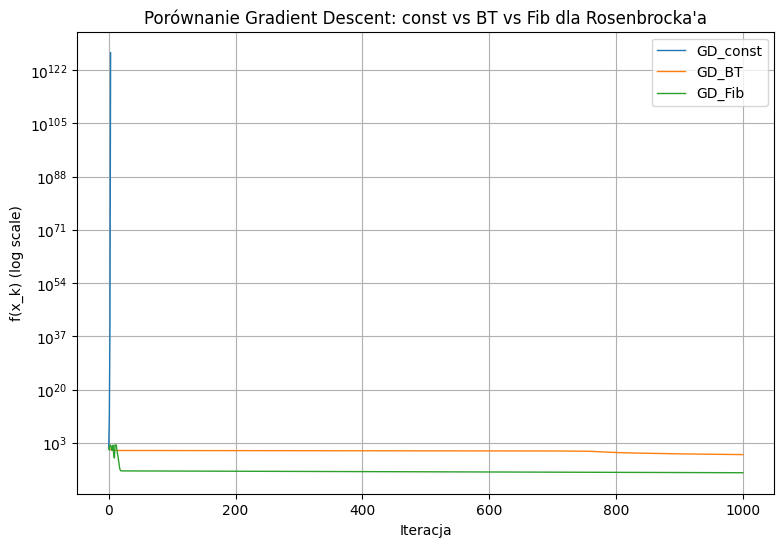

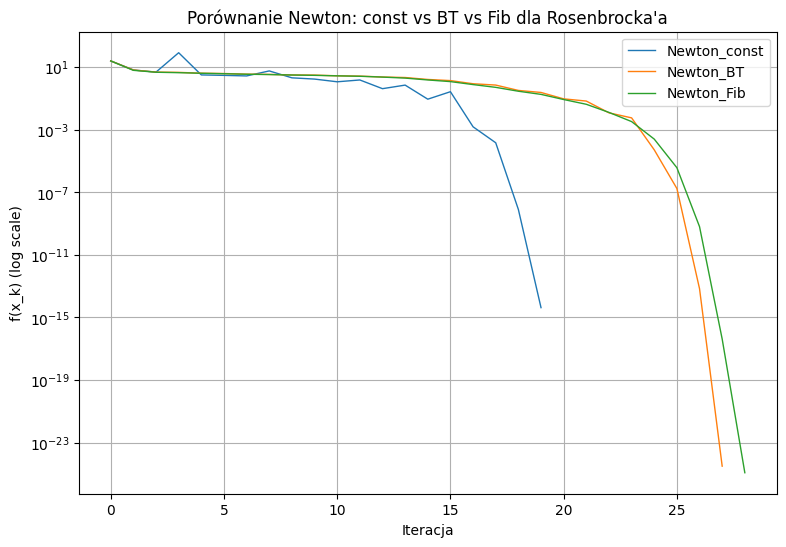

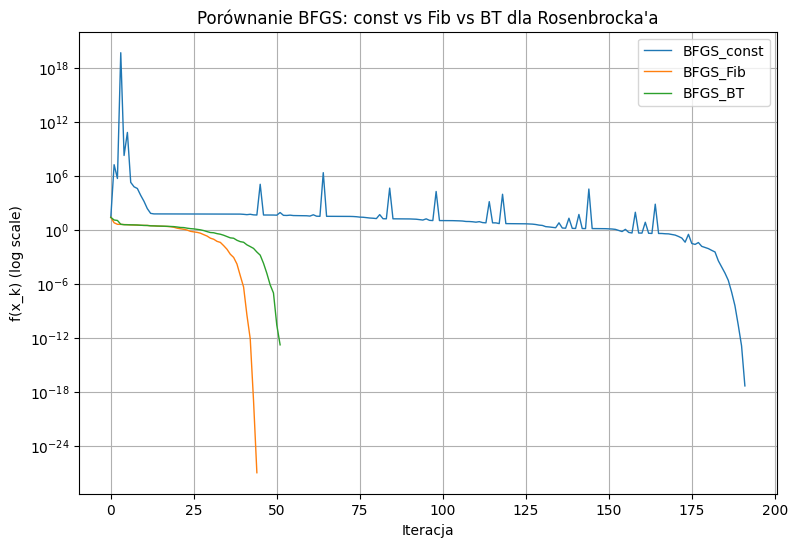

In [67]:
def plot_group(results_dict, title, ylabel="f(x_k) (log scale)"):
    if not results_dict:
        print(f"Brak wyników dla grupy: {title}")
        return

    plt.figure(figsize=(9,6))
    for name, (x_star, visited, vals) in results_dict.items():
        plt.plot(vals, label=name, linewidth=1)
    plt.yscale('log')
    plt.xlabel("Iteracja")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_group(results_gd, "Porównanie Gradient Descent: const vs BT vs Fib dla Rosenbrocka'a")
plot_group(results_newton, "Porównanie Newton: const vs BT vs Fib dla Rosenbrocka'a")
plot_group(results_bfgs, "Porównanie BFGS: const vs Fib vs BT dla Rosenbrocka'a")

### Funkcja wyjściowa

In [68]:
x0 = np.array([0,0])
gd_methods = {
    "GD_const": lambda: GD_const_alpha(f, grad_f, x0, eps, alpha=0.5),
    "GD_BT":    lambda: GD_BT(f, grad_f, x0, eps, alpha_0=1.0, rho=0.8, c=0.1, max_iter=max_iters),
    "GD_Fib":   lambda: GD_Fib(f, grad_f, x0, eps, alpha_min=1e-6, alpha_max=1.0, n_iter_Fib=20, max_iters=max_iters)
}

newton_methods = {
    "Newton_const": lambda: Newton_const_alpha(f, grad_f, hes_f, x0, eps, alpha=1.0, max_iter=max_iters),
    "Newton_BT":    lambda: Newton_BT(f, grad_f, hes_f, x0, eps, alpha_0=1.0, rho=0.8, c=0.1, max_iters=max_iters),
    "Newton_Fib":   lambda: Newton_Fib(f, grad_f, hes_f, x0, eps, alpha_min=1e-6, alpha_max=1.0, n_iter_Fib=20, max_iter=max_iters)
}

bfgs_methods = {
    "BFGS_const": lambda: BFGS(f, grad_f, x0, eps, beta=0.1, alpha=1.0, max_iters=max_iters),
    "BFGS_Fib":   lambda: BFGS_fib(f, grad_f, x0, eps, beta=0.1, max_iters=max_iters, alpha_min=alpha_min, alpha_max=alpha_max, n_iter_Fib=n_iter_Fib),
    "BFGS_BT":    lambda: BFGS_BT(f, grad_f, x0, eps, beta=0.1, alpha_0=1.0, rho=0.8, c=0.1, max_iters=max_iters)
}

In [69]:
results_gd = {}
results_newton = {}
results_bfgs = {}

for name, fn in gd_methods.items():
    x_star, visited, vals = fn()
    results_gd[name] = (x_star, visited, vals)
    print(f"\n--- {name} ---")
    print_result(name, visited, vals)


--- GD_const ---
GD_const: zakończyło przed 1000-tą iteracją (wykonano 40).
GD_const: ostatni punkt: [-0.6748316  -0.52129846], wartość: 0.9633159269246755

--- GD_BT ---
GD_BT: zakończyło przed 1000-tą iteracją (wykonano 66).
GD_BT: ostatni punkt: [-0.67483161 -0.52129845], wartość: 0.9633159269246756

--- GD_Fib ---
GD_Fib: zakończyło przed 1000-tą iteracją (wykonano 20).
GD_Fib: ostatni punkt: [-0.67483161 -0.52129845], wartość: 0.9633159269246756


In [70]:
for name, fn in newton_methods.items():
    x_star, visited, vals = fn()
    results_newton[name] = (x_star, visited, vals)
    print(f"\n--- {name} ---")
    print_result(name, visited, vals)


--- Newton_const ---
Newton_const: zakończyło przed 1000-tą iteracją (wykonano 3).
Newton_const: ostatni punkt: [-0.67483161 -0.52129846], wartość: 0.9633159269246756

--- Newton_BT ---
Newton_BT: zakończyło przed 1000-tą iteracją (wykonano 3).
Newton_BT: ostatni punkt: [-0.67483161 -0.52129846], wartość: 0.9633159269246756

--- Newton_Fib ---
Newton_Fib: zakończyło przed 1000-tą iteracją (wykonano 4).
Newton_Fib: ostatni punkt: [-0.67483161 -0.52129845], wartość: 0.9633159269246755


In [71]:
for name, fn in bfgs_methods.items():
    x_star, visited, vals = fn()
    results_bfgs[name] = (x_star, visited, vals)
    print(f"\n--- {name} ---")
    print_result(name, visited, vals)


--- BFGS_const ---
BFGS_const: zakończyło przed 1000-tą iteracją (wykonano 11).
BFGS_const: ostatni punkt: [-0.67483161 -0.52129846], wartość: 0.9633159269246756

--- BFGS_Fib ---
BFGS_Fib: zakończyło przed 1000-tą iteracją (wykonano 12).
BFGS_Fib: ostatni punkt: [-0.67483161 -0.52129846], wartość: 0.9633159269246754

--- BFGS_BT ---
BFGS_BT: zakończyło przed 1000-tą iteracją (wykonano 10).
BFGS_BT: ostatni punkt: [-0.67483153 -0.5212983 ], wartość: 0.9633159269247011


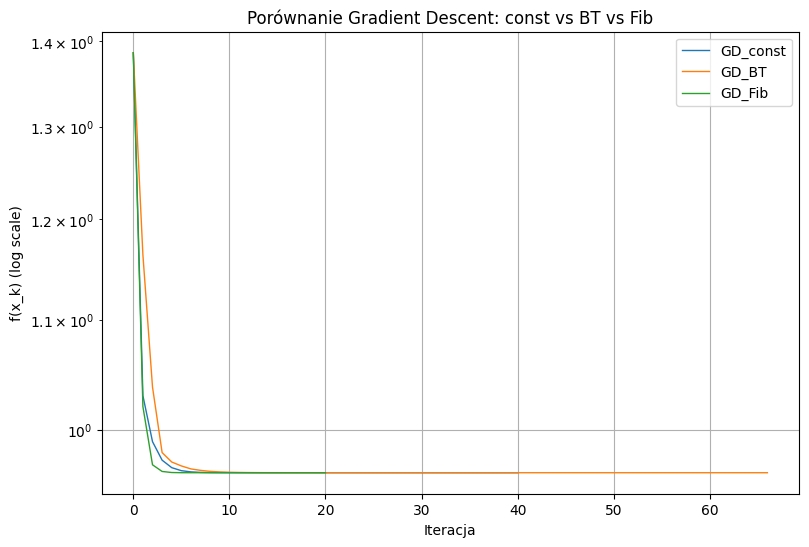

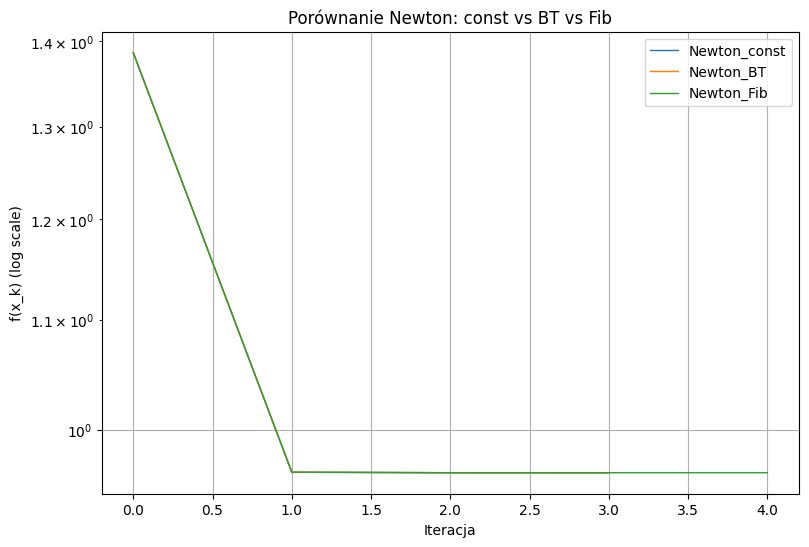

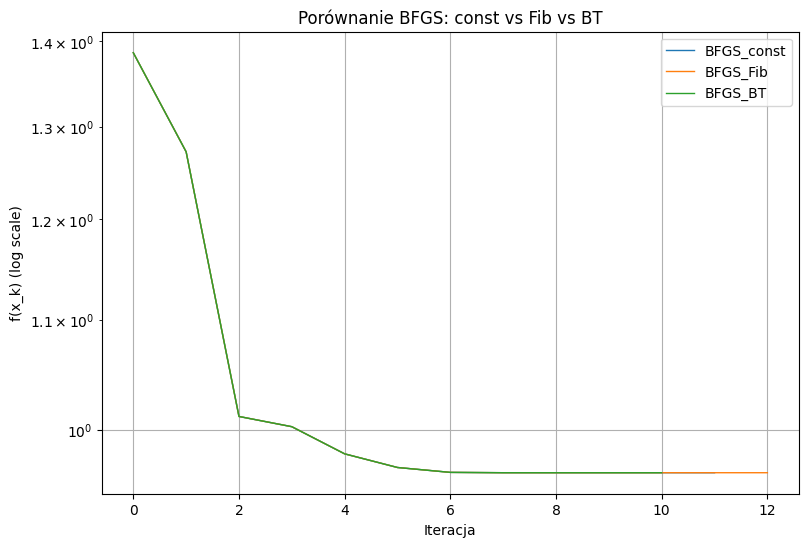

In [72]:
plot_group(results_gd, "Porównanie Gradient Descent: const vs BT vs Fib")
plot_group(results_newton, "Porównanie Newton: const vs BT vs Fib")
plot_group(results_bfgs, "Porównanie BFGS: const vs Fib vs BT")

## Optymalizacja regresji logistycznej z regularyzacją

In [73]:
import pandas as pd

In [74]:
df = pd.read_csv("moons.csv")
X = df[["x1", "x2"]].values
y = df["y"].values.astype(int)

print(df.head())

         x1        x2    y
0 -1.106897  0.042293 -1.0
1  0.956800  0.456750 -1.0
2  0.733516  0.584617 -1.0
3  1.111407 -0.309214  1.0
4  0.209082  0.000657  1.0


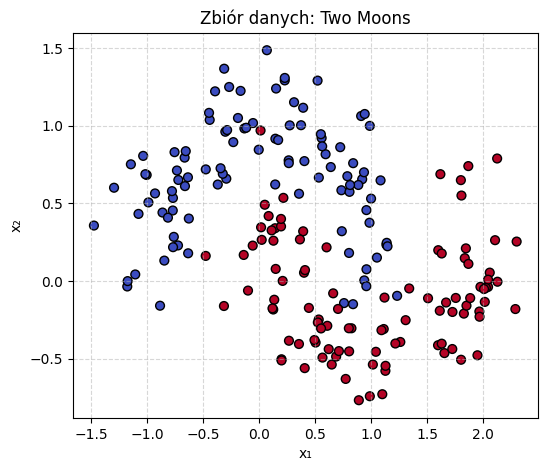

In [75]:
# Wizualizacja
plt.figure(figsize=(6, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", s=40, edgecolor="k")
plt.title("Zbiór danych: Two Moons")
plt.xlabel("x₁")
plt.ylabel("x₂")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

Implementacja funkcji celu oraz jej gradientu i macierzy Hessego

In [34]:
def loss_function(x, lam=1.0):
    a, beta = x[0], x[1:]
    z = a + X.dot(beta)
    losses = np.logaddexp(0, -y * z) 
    return losses.mean() + lam * np.dot(beta, beta)

In [35]:
def gradient(x, lam=1.0):
    a, beta = x[0], x[1:]
    n, p = X.shape
    z = a + X.dot(beta)
    s = sigmoid(-y * z)
    dl_dz = -y * s                    
    grad_a = dl_dz.mean()            
    grad_beta = (X.T.dot(dl_dz)) / n + 2.0 * lam * beta
    return np.concatenate(([grad_a], grad_beta))

In [36]:
# Zakładamy ze y przyjmuje wartosci 1 oraz -1
def hessian(x, lam = 1.0):
    a, beta = x[0], x[1:]
    n, p = X.shape
    z = a + X.dot(beta)
    s = sigmoid(-y * z)
    w = s * (1 - s)

    H_aa = np.mean(w)  
    H_ab = np.mean(w.reshape(-1, 1) * X, axis=0)  
    W = np.diag(w)
    H_bb = X.T @ W @ X  / n + 2 * lam * np.eye(p) 

    H = np.zeros((p+1, p+1))
    H[0, 0] = H_aa
    H[0, 1:] = H_ab
    H[1:, 0] = H_ab
    H[1:, 1:] = H_bb
    return H

### Optymalizacja liniowa z użyciem wcześniej zaimplementowanych metod

Liczba iteracji (GD_const_alpha): 55
Liczba iteracji (BFGS_BT): 11

Najlepszy model: BFGS_BT
a_best = -0.0316
beta_best = [ 0.11123516 -0.08839392]
Minimalna wartość funkcji straty: 0.670975
Liczba iteracji (najlepszy): 11
Poprawnie sklasyfikowane (wg przewidywań): 156
Niepoprawnie sklasyfikowane (wg przewidywań): 44
Dokładność (wg przewidywań): 78.00%


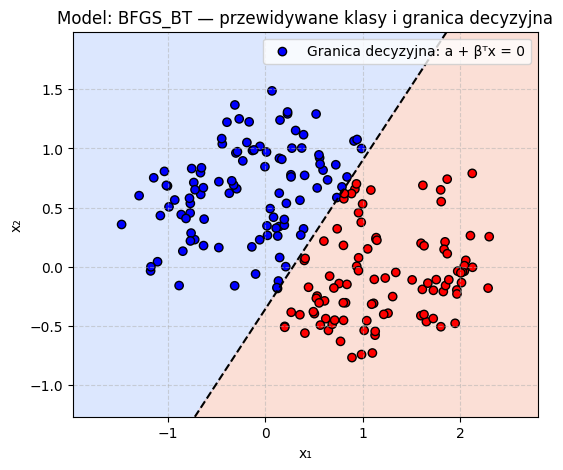

In [37]:
def get_last_x(result):
    return result[0], len(result[1])
x0 = np.array([0,0,0])

gd_result, gd_iters = get_last_x(GD_const_alpha(loss_function, gradient, x0=x0, eps=1e-5, alpha=0.5))
bfgs_result, bfgs_iters = get_last_x(BFGS_BT(loss_function, gradient, x0, eps=1e-5, beta=0.1, alpha_0=1.0, max_iters=1000, rho=0.8, c=0.1))

dict_results = {
    'GD_const_alpha': (gd_result, loss_function(gd_result), gd_iters),
    'BFGS_BT': (bfgs_result, loss_function(bfgs_result), bfgs_iters)
}

best_name, (best_params, best_loss, best_iters) = min(dict_results.items(), key=lambda x: x[1][1])

a_best = best_params[0]
beta_best = best_params[1:]

print(f"Liczba iteracji (GD_const_alpha): {dict_results['GD_const_alpha'][2]}")
print(f"Liczba iteracji (BFGS_BT): {dict_results['BFGS_BT'][2]}")
print()
print(f"Najlepszy model: {best_name}")
print(f"a_best = {a_best:.4f}")
print(f"beta_best = {beta_best}")
print(f"Minimalna wartość funkcji straty: {best_loss:.6f}")
print(f"Liczba iteracji (najlepszy): {best_iters}")

decision_values = a_best + X.dot(beta_best)    
predicted = np.sign(decision_values)       
predicted[predicted == 0] = 1                 

correct_mask = (predicted == y)
n_correct = correct_mask.sum()
n_incorrect = len(y) - n_correct
print(f"Poprawnie sklasyfikowane (wg przewidywań): {n_correct}")
print(f"Niepoprawnie sklasyfikowane (wg przewidywań): {n_incorrect}")
print(f"Dokładność (wg przewidywań): {n_correct / len(y):.2%}")

xx, yy = np.meshgrid(np.linspace(X[:,0].min()-0.5, X[:,0].max()+0.5, 300),
                     np.linspace(X[:,1].min()-0.5, X[:,1].max()+0.5, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
zz = a_best + grid.dot(beta_best)
zz = zz.reshape(xx.shape)

plt.figure(figsize=(6,5))
pred_grid = np.sign(zz)
pred_grid[pred_grid == 0] = 1
plt.contourf(xx, yy, pred_grid, levels=[-1,0,1], alpha=0.3, cmap="coolwarm")

plt.contour(xx, yy, zz, levels=[0], colors='k', linewidths=1.5, linestyles='--')

colors = np.where(predicted == 1, "red", "blue")
plt.scatter(X[:,0], X[:,1], c=colors, edgecolor='k', label='Punkty danych')

plt.title(f"Model: {best_name} — przewidywane klasy i granica decyzyjna")
plt.xlabel("x₁")
plt.ylabel("x₂")
plt.legend(["Granica decyzyjna: a + βᵀx = 0"])
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

##### Punkty nie są idealnie oddzielone, bo nie da się ich oddzielić zależnością liniową.

### Aktywacja funkcji nieliniowej

In [41]:
def poly_features(X):
    x1, x2 = X[:, 0], X[:, 1]
    return np.column_stack([
        x1, x2,                
        x1**2, x1*x2, x2**2,    
        x1**3, x1**2*x2, x1*x2**2, x2**3  
    ])

X_poly = poly_features(X)

def loss_function(x, lam=1.0):
    a = float(x[0])
    beta = np.asarray(x[1:], dtype=float)
    z = a + X_poly.dot(beta)
    losses = np.logaddexp(0, -y * z)
    return losses.mean() + lam * np.dot(beta, beta)

def gradient(x, lam=1.0):
    a = float(x[0])
    beta = np.asarray(x[1:], dtype=float)
    n, p = X_poly.shape
    z = a + X_poly.dot(beta)
    s = 1 / (1 + np.exp(y * z))    
    dl_dz = -y * s
    grad_a = dl_dz.mean()
    grad_beta = (X_poly.T.dot(dl_dz)) / n + 2.0 * lam * beta
    return np.concatenate(([grad_a], grad_beta))

def hessian(x, lam=1.0):
    a = float(x[0])
    beta = np.asarray(x[1:], dtype=float)
    n, p = X_poly.shape            
    z = a + X_poly.dot(beta)         
    s = 1.0 / (1.0 + np.exp(- y * z))  
    w = s * (1.0 - s)             
    H_aa = np.mean(w)  
    H_ab = np.mean(w.reshape(-1, 1) * X_poly, axis=0)  
    W = np.diag(w)
    H_bb = X_poly.T @ W @ X_poly  / n + 2 * lam * np.eye(p) 

    H = np.zeros((p+1, p+1))
    H[0, 0] = H_aa
    H[0, 1:] = H_ab
    H[1:, 0] = H_ab
    H[1:, 1:] = H_bb
    return H

In [44]:
x0 = np.zeros(X_poly.shape[1] + 1)  
res = Newton_BT(loss_function, gradient, hessian, x0=x0, eps=1e-5, alpha_0=1, rho=0.8, c=0.1, max_iters_BT=10000, max_iters=200)

a_best = -0.2331
beta_best = [ 0.07138706 -0.07747771  0.04826425 -0.01606149 -0.04218505  0.16308786
 -0.03725352  0.00802642 -0.05663238]
Minimalna wartość funkcji straty: 0.608685
Poprawnie sklasyfikowane: 143
Niepoprawnie sklasyfikowane: 57
Dokładność: 71.50%


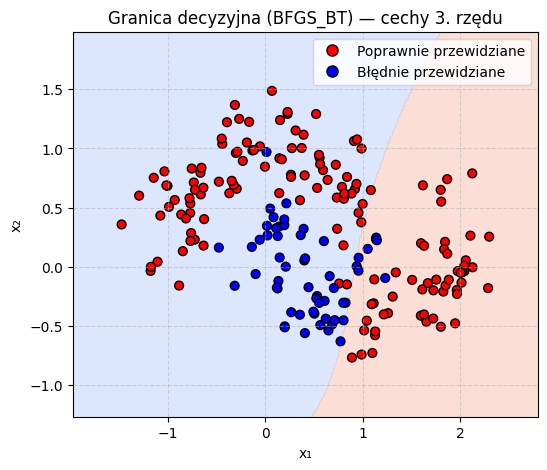

In [45]:
a_best, beta_best = res[0][0], res[0][1:]
best_loss = loss_function(res[0])

print(f"a_best = {a_best:.4f}")
print(f"beta_best = {beta_best}")
print(f"Minimalna wartość funkcji straty: {best_loss:.6f}")

xx, yy = np.meshgrid(np.linspace(X[:,0].min()-0.5, X[:,0].max()+0.5, 300),
                     np.linspace(X[:,1].min()-0.5, X[:,1].max()+0.5, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_poly = poly_features(grid)
zz = a_best + grid_poly.dot(beta_best)
zz = zz.reshape(xx.shape)

decision_values = a_best + X_poly.dot(beta_best)
correct_mask = y * decision_values > 0 

colors = np.where(correct_mask, "red", "blue")

n_correct = np.sum(correct_mask)
n_incorrect = len(correct_mask) - n_correct

print(f"Poprawnie sklasyfikowane: {n_correct}")
print(f"Niepoprawnie sklasyfikowane: {n_incorrect}")
print(f"Dokładność: {n_correct / len(correct_mask):.2%}")

plt.figure(figsize=(6,5))
plt.contourf(xx, yy, zz > 0, cmap="coolwarm", alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=colors, s=40, edgecolor="k")

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Poprawnie przewidziane', 
           markerfacecolor='red', markeredgecolor='k', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Błędnie przewidziane', 
           markerfacecolor='blue', markeredgecolor='k', markersize=8)
]
plt.legend(handles=legend_elements, loc='upper right')

plt.title(f"Granica decyzyjna ({best_name}) — cechy 3. rzędu")
plt.xlabel("x₁"); plt.ylabel("x₂"); plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

##### Mamy niższą wartość funkcji straty, ale predykcja nawet się pogorszyła

### Testowanie różnych wartości regularyzacji

In [71]:
x0 = np.zeros(X_poly.shape[1] + 1) 
res = Newton_BT(lambda x : loss_function(x = x, lam = 0.0001), lambda x : gradient(x = x, lam = 0.0001), lambda x : hessian(x = x, lam = 0.0001), x0=x0, eps=1e-5, alpha_0=1, rho=0.8, c=0.1, max_iters_BT=10000, max_iters=200)

a_best = 4.9761
beta_best = [ -2.86291067  -6.58086937 -11.27928347   0.59954034  -0.63608559
   8.20229854  -1.5769632    4.06346322  -1.1336291 ]
Minimalna wartość funkcji straty: 267.142615
Poprawnie sklasyfikowane: 194
Niepoprawnie sklasyfikowane: 6
Dokładność: 97.00%


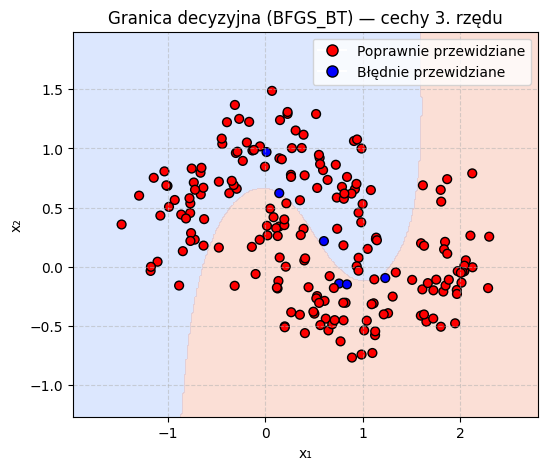

In [ ]:
a_best, beta_best = res[0][0], res[0][1:]
best_loss = loss_function(res[0])

print(f"a_best = {a_best:.4f}")
print(f"beta_best = {beta_best}")
print(f"Minimalna wartość funkcji straty: {best_loss:.6f}")

xx, yy = np.meshgrid(np.linspace(X[:,0].min()-0.5, X[:,0].max()+0.5, 300),
                     np.linspace(X[:,1].min()-0.5, X[:,1].max()+0.5, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_poly = poly_features(grid)
zz = a_best + grid_poly.dot(beta_best)
zz = zz.reshape(xx.shape)

decision_values = a_best + X_poly.dot(beta_best)
correct_mask = y * decision_values > 0 

colors = np.where(correct_mask, "red", "blue")

n_correct = np.sum(correct_mask)
n_incorrect = len(correct_mask) - n_correct

print(f"Poprawnie sklasyfikowane: {n_correct}")
print(f"Niepoprawnie sklasyfikowane: {n_incorrect}")
print(f"Dokładność: {n_correct / len(correct_mask):.2%}")

plt.figure(figsize=(6,5))
plt.contourf(xx, yy, zz > 0, cmap="coolwarm", alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=colors, s=40, edgecolor="k")

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Poprawnie przewidziane', 
           markerfacecolor='red', markeredgecolor='k', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Błędnie przewidziane', 
           markerfacecolor='blue', markeredgecolor='k', markersize=8)
]
plt.legend(handles=legend_elements, loc='upper right')

plt.title(f"Granica decyzyjna ({best_name}) — cechy 3. rzędu")
plt.xlabel("x₁"); plt.ylabel("x₂"); plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

##### Dla bardzo małej regularyzacji funkcja osiąga znacznie lepsze wyniki - dopasowanie jest bliższe oczekiwanemu kształtowi i bardziej falowane

Dla sporej regularyzacji:

In [73]:
x0 = np.zeros(X_poly.shape[1] + 1) 
res = Newton_BT(lambda x : loss_function(x = x, lam = 1000), lambda x : gradient(x = x, lam = 1000), lambda x : hessian(x = x, lam = 1000), x0=x0, eps=1e-5, alpha_0=1, rho=0.8, c=0.1, max_iters_BT=10000, max_iters=200)

a_best = -0.0006
beta_best = [ 1.24425240e-04 -9.40989834e-05  1.27702246e-04 -1.42254331e-05
 -5.43825439e-05  3.44362199e-04 -4.29993715e-05  1.41346600e-05
 -7.09474449e-05]
Minimalna wartość funkcji straty: 0.692808
Poprawnie sklasyfikowane: 145
Niepoprawnie sklasyfikowane: 55
Dokładność: 72.50%


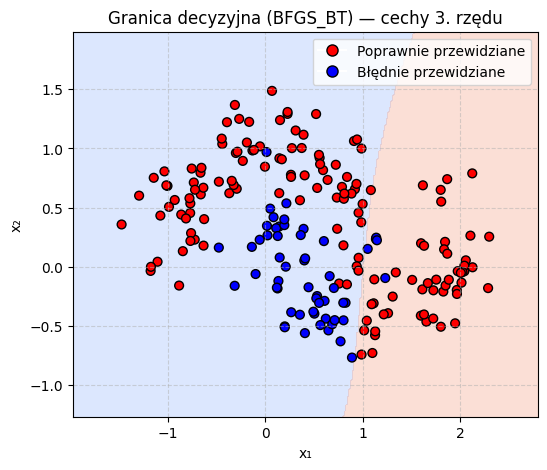

In [74]:
a_best, beta_best = res[0][0], res[0][1:]
best_loss = loss_function(res[0])

print(f"a_best = {a_best:.4f}")
print(f"beta_best = {beta_best}")
print(f"Minimalna wartość funkcji straty: {best_loss:.6f}")

xx, yy = np.meshgrid(np.linspace(X[:,0].min()-0.5, X[:,0].max()+0.5, 300),
                     np.linspace(X[:,1].min()-0.5, X[:,1].max()+0.5, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_poly = poly_features(grid)
zz = a_best + grid_poly.dot(beta_best)
zz = zz.reshape(xx.shape)

decision_values = a_best + X_poly.dot(beta_best)
correct_mask = y * decision_values > 0 

colors = np.where(correct_mask, "red", "blue")

n_correct = np.sum(correct_mask)
n_incorrect = len(correct_mask) - n_correct

print(f"Poprawnie sklasyfikowane: {n_correct}")
print(f"Niepoprawnie sklasyfikowane: {n_incorrect}")
print(f"Dokładność: {n_correct / len(correct_mask):.2%}")

plt.figure(figsize=(6,5))
plt.contourf(xx, yy, zz > 0, cmap="coolwarm", alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=colors, s=40, edgecolor="k")

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Poprawnie przewidziane', 
           markerfacecolor='red', markeredgecolor='k', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Błędnie przewidziane', 
           markerfacecolor='blue', markeredgecolor='k', markersize=8)
]
plt.legend(handles=legend_elements, loc='upper right')

plt.title(f"Granica decyzyjna ({best_name}) — cechy 3. rzędu")
plt.xlabel("x₁"); plt.ylabel("x₂"); plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

##### Linia jest mniej krzywa, model dopasowuje się gorzej